In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg
import scipy

print(np.__version__)
print(matplotlib.__version__)
print(scipy.__version__)

1.24.2
3.6.3
1.10.1


In [2]:
def make_plot_3d(y, t, title):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(y[:, 0], y[:, 1], y[:, 2], lw=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title(title, fontsize=16)
    plt.show()

def make_plot_2d(y, t, title):
    fig = plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=16)
    plt.axis('off')
    
    ax1 = fig.add_subplot(221)
    ax1.plot(y[:, 1], y[:, 0])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'$ log(y_2) $')
    ax1.set_ylabel(r'$ log(y_1) $')

    ax2 = fig.add_subplot(223)
    ax2.plot(y[:, 1], y[:, 2])
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$ log(y_2) $')
    ax2.set_ylabel(r'$ log(y_3) $')

    ax3 = fig.add_subplot(322)
    ax3.plot(t, y[:, 2])
    ax3.set_yscale('log')
    ax3.set_xlabel(r'$ t $')
    ax3.set_ylabel(r'$ log(y_3) $')

    ax4 = fig.add_subplot(324)
    ax4.plot(t, y[:, 1])
    ax4.set_yscale('log')
    ax4.set_xlabel(r'$ t $')
    ax4.set_ylabel(r'$ log(y_2) $')

    ax5 = fig.add_subplot(326)
    ax5.plot(t, y[:, 0])
    ax5.set_yscale('log')
    ax5.set_xlabel(r'$ t $')
    ax5.set_ylabel(r'$ log(y_1) $')

    plt.show()

# Non-stiff system (VIII.11.5)

$ x' = -10(x - y) $

$ y' = -xz + 28x - y $

$ z' = xy - 8/3z $

Conditions:

$ x(0) = y(0) = z(0) = 1 $

$ 0 < t <= 50 $

In [3]:
def f1(t, y): # non-stiff system; t unused (autonomous)
    f = np.array(np.zeros(3)) #[0, 0, 0]
    f[0] = -10*(y[0] - y[1])
    f[1] = -y[0]*y[2] + 28*y[0] - y[1]
    f[2] = y[0]*y[1] - 8/3 * y[2]

    return f

## Runge–Kutta methods (explicit)
Used "default" (RK4) 4-stage and 4th-order method from Wikipedia.

In [4]:
def rungekutta_explicit(f, y0, t0, t_end, h):
    tn = t0
    yn = y0
    y = list()
    t = list()

    while tn < t_end:
        k1 = f(tn, yn) #RK4
        k2 = f(tn + h/2, yn + h/2 * k1)
        k3 = f(tn + h/2, yn + h/2 * k2)
        k4 = f(tn + h, yn + h * k3)

        yn1 = yn + h/6 * (k1 + 2*k2 + 2*k3 + k4)

        y.append(yn)
        t.append(tn)

        tn += h
        yn = yn1

    y = np.array(y)
    t = np.array(t)

    return y, t

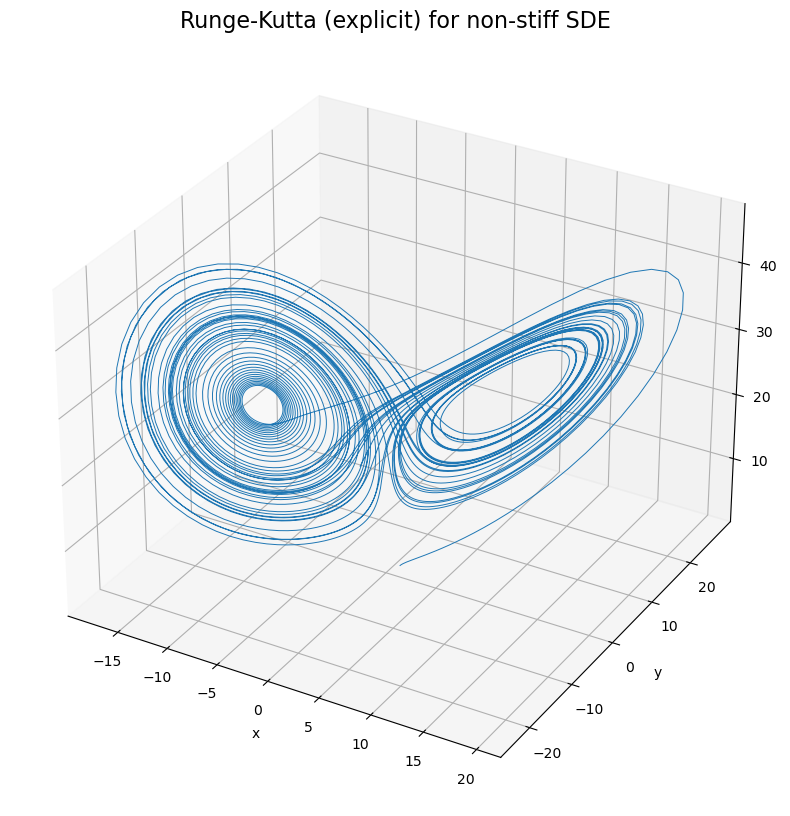

In [5]:
y_rke, t_rke = rungekutta_explicit(f1, y0=np.array([1, 1, 1]), t0=0, t_end=50, h=0.01)

make_plot_3d(y_rke, t_rke, "Runge-Kutta (explicit) for non-stiff SDE")

## Adams methods
Used the following method:

$ y_n = y_{n-1} + \frac{h}{2}[3f(t_{n-1}, y_{n-1}) - f(t_{n-2}, y_{n-2})] $

In [6]:
def adams_explicit(f, y0, t0, t_end, h):
    lp = 2 # points to be pre-calculated
    y_launch, t_launch = rungekutta_explicit(f, y0, t0, t0 + lp*h, h)

    t0 += (lp + 1)*h
    tn = t0
    
    y = list(y_launch)
    t = list(t_launch)

    while tn < t_end:
        yn = y[-1] + h/2 * (3*f(t[-1], y[-1]) - f(t[-2], y[-2]))
        
        y.append(yn)
        t.append(tn)
        tn += h

    y = np.array(y)
    t = np.array(t)

    return y, t

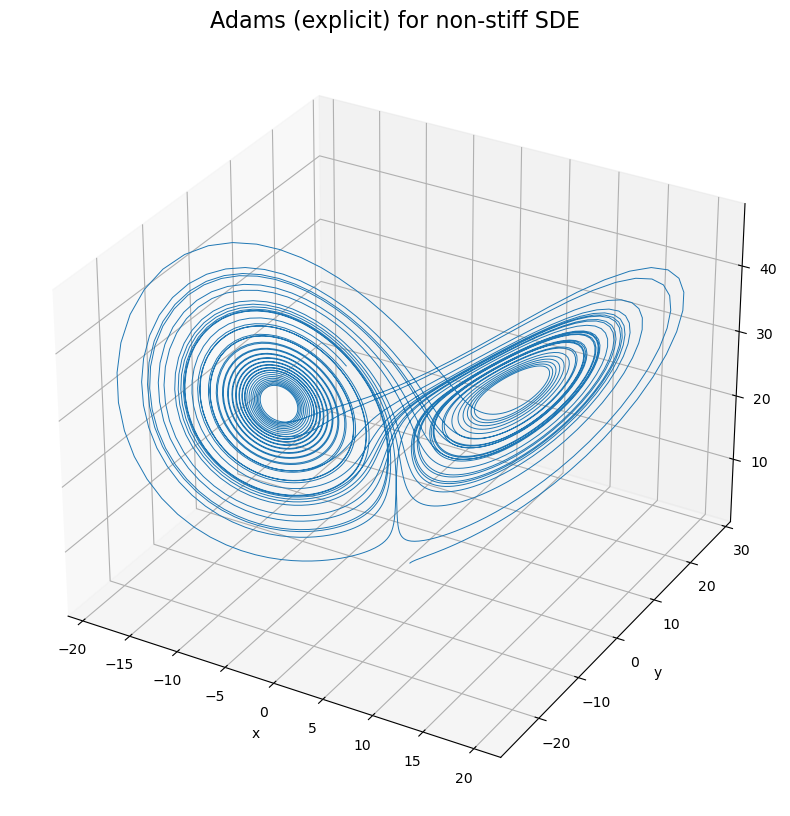

In [7]:
y_a, t_a = adams_explicit(f1, y0=np.array([1, 1, 1]), t0=0, t_end=50, h=0.01)

make_plot_3d(y_a, t_a, "Adams (explicit) for non-stiff SDE")

## BDF
Used BDF2 formula from Wikipedia:

$ y_n -\frac{4}{3}y_{n-1} + \frac{1}{3}y_{n-2} = \frac{2}{3}hf(t_n, y_n) $ 

In [8]:
def bdf(f, y0, t0, t_end, h):
    lp = 2 # points to be pre-calculated
    y_launch, t_launch = rungekutta_explicit(f, y0, t0, t0 + lp*h, h)

    t0 += (lp + 1)*h
    tn = t0
    
    y = list(y_launch)
    t = list(t_launch)

    while tn < t_end:
        phi = lambda yn: yn - 4/3 * y[-1] + 1/3 * y[-2] - 2/3 * h*f(tn, yn)
        yn = scipy.optimize.fsolve(phi, y[-1])
        
        y.append(yn)
        t.append(tn)
        tn += h

    y = np.array(y)
    t = np.array(t)

    return y, t

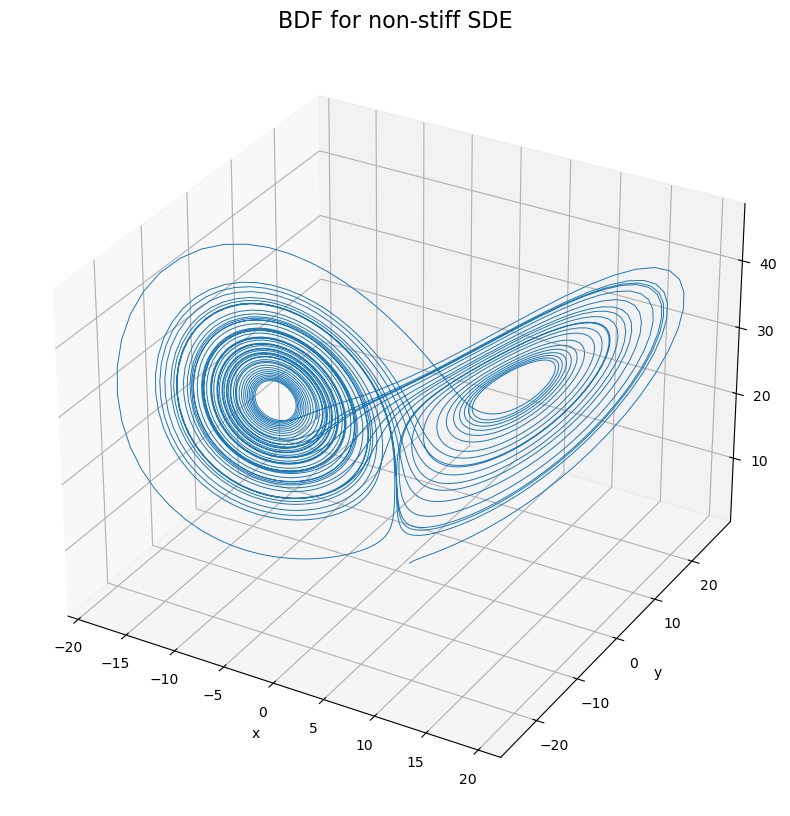

In [9]:
y_bdf, t_bdf = bdf(f1, y0=np.array([1, 1, 1]), t0=0, t_end=50, h=0.01)

make_plot_3d(y_bdf, t_bdf, "BDF for non-stiff SDE")

# Stiff system (IX.9.8) (Field & Noyes "Oregonator")

$ \frac{d}{dt}y_{1} = 77.27(y_2 + y_1(1 - 8.375*10^{-6}y_1 - y_2)) $

$ \frac{d}{dt}y_{2} = \frac{1}{77.27}(y_3 - (1 + y_1)y_2) $

$ \frac{d}{dt}y_{3} = 0.161(y_1 - y_3) $

Conditions:

$ y_i(t_0) > 0,~ y_i(t_0) \approx 0 $  

$ \Delta t = 800 $

In [10]:
def f2(t, y): # stiff system; t unused (autonomous)
    f = np.array(np.zeros(3)) #[0, 0, 0]
    f[0] = 77.27*(y[1] + y[0]*(1 - 8.375e-6*y[0] - y[1]))
    f[1] = 1/77.27 * (y[2] - (1 + y[0])*y[1])
    f[2] = 0.161*(y[0] - y[2])

    return f

## Runge-Kutta methods (implicit)
Used modified Euler method (2nd order) from Wikipedia:

$ y_{n} = y_{n-1} + \frac{h}{2}[f(t_{n-1}, y_{n-1}) + f(t_n, y_n)] $

In [11]:
def rungekutta_implicit(f, y0, t0, t_end, h):
    y = list([y0, ])
    t = list([t0, ])
    tn = t0

    while tn < t_end:
        phi = lambda yn: yn - y[-1] - h/2 * (f(t[-1], y[-1]) + f(tn, yn))
        yn = scipy.optimize.fsolve(phi, y[-1])
        
        y.append(yn)
        t.append(tn)
        tn += h

    y = np.array(y)
    t = np.array(t)

    return y, t

In [12]:
y_rki, t_rki = rungekutta_implicit(f2, y0=np.array([1, 1, 1]), t0=0, t_end=800, h=0.001)

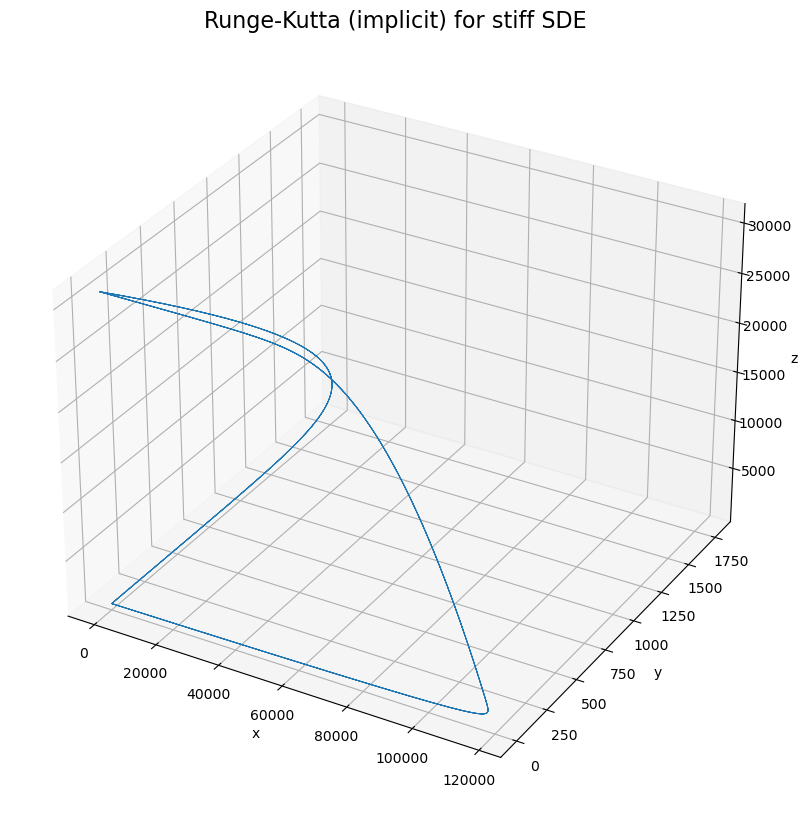

In [13]:
make_plot_3d(y_rki, t_rki, "Runge-Kutta (implicit) for stiff SDE")

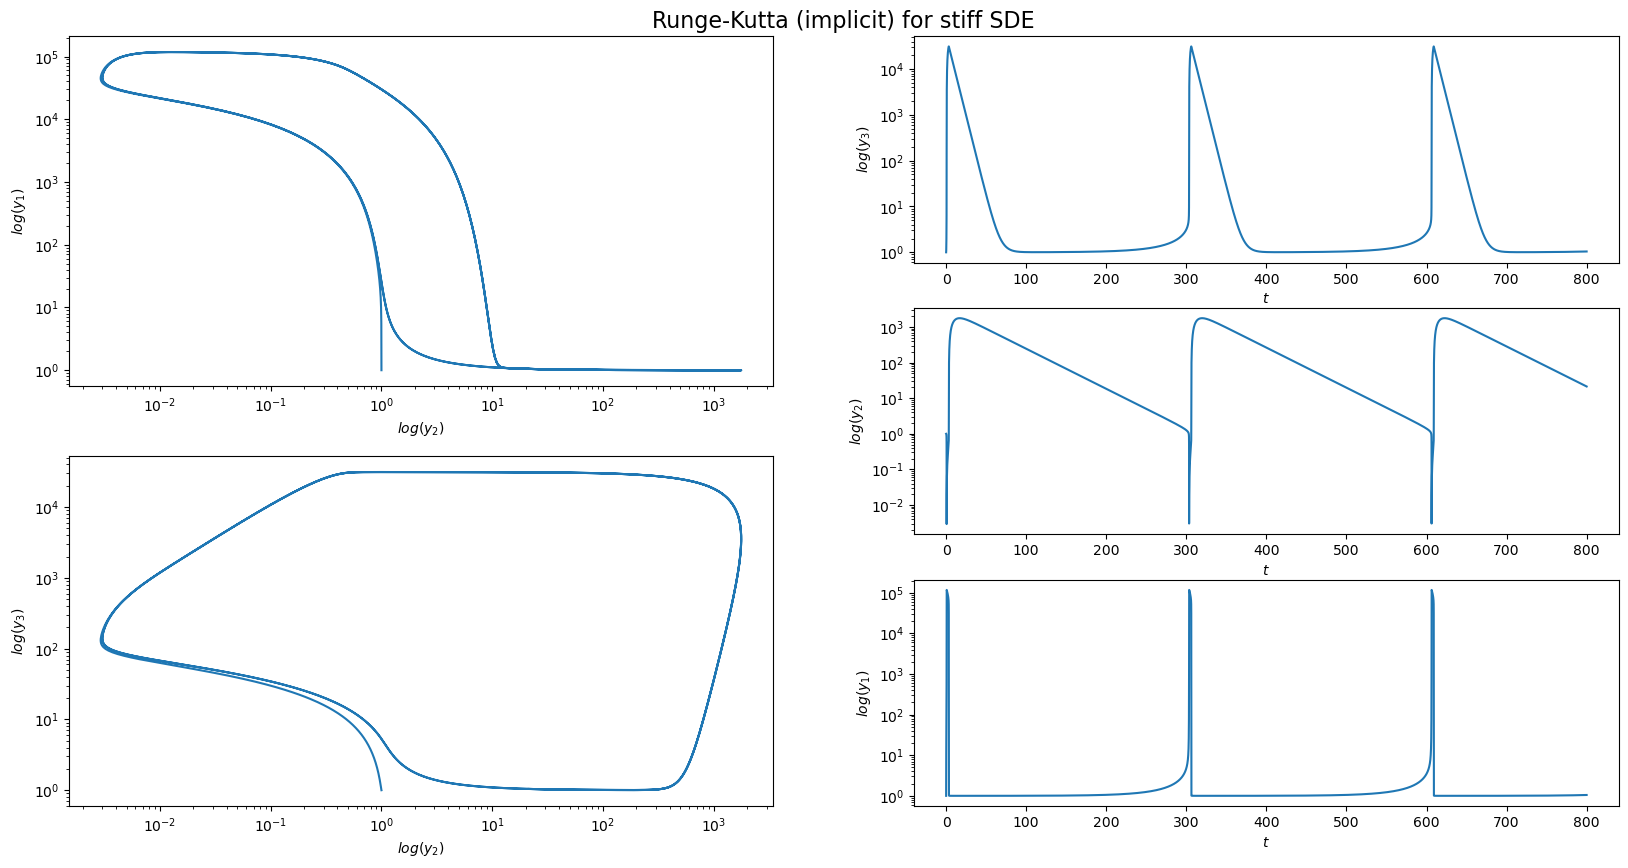

In [14]:
make_plot_2d(y_rki, t_rki, "Runge-Kutta (implicit) for stiff SDE")

## Rosenbrock methods
Used CROS scheme:

$ (E - \frac{1 + i}{2}hJ)w = f(t_0 + \frac{h}{2}, y_0) $

$ y_1 = y_0 + h*Re(w) $

In [15]:
def rosenbrock(f, y0, t0, t_end, h):
    pass